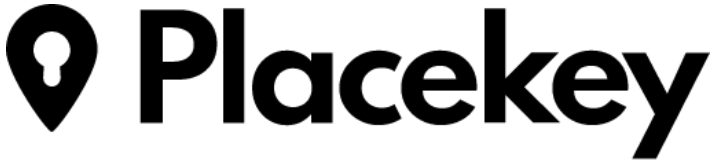

# Joining POI datasets with Placekey
This tutorial will teach you how to join POI datasets with Placekey using Python in a Google Colab environment.

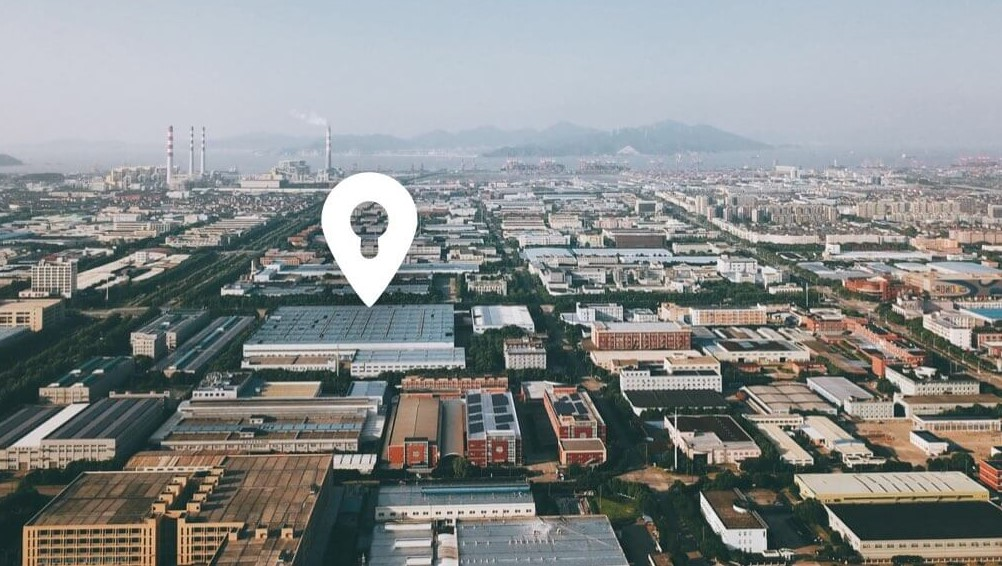

# Getting Started
Before moving forward, make sure you are familiar with Placekey. There are a growing number of resources available:
*   [Placekey website](https://www.placekey.io/)
*   [Medium article](https://medium.com/spatial-data-science/placekey-the-universal-identifier-for-the-physical-world-73d8d2d8ab9c)
*   [Placekey whitepaper](https://docs.placekey.io/Placekey_Technical_White_Paper.pdf)
*   [And more](https://www.placekey.io/blog)


### Imports and Installations
In the first code block, we install the `placekey` package in our Google Colab environment and import the necessary packages.

In [1]:
!pip install placekey

from placekey.api import PlacekeyAPI
import pandas as pd
from ast import literal_eval
import json

Defaulting to user installation because normal site-packages is not writeable


### Set API key
Replace the asterisks below with your Placekey API key. If you don’t have one yet, [it’s completely free](https://www.placekey.io/).

In [2]:
placekey_api_key = "W2Qek2tre2mgHsduQ1hKPechjhtuTnKF" # fill this in with your personal API key (do not share publicly)

pk_api = PlacekeyAPI(placekey_api_key)

# Datasets

This tutorial uses two POI datasets: SafeGraph Patterns and Forsyth County polling locations/results.

### Define functions
First, define a couple functions to make it easier to read in the datasets.

In [3]:
def pd_read_csv_local(filepath, dtype=None, converters=None, encoding=None):
    return pd.read_csv(filepath, dtype=dtype, converters=converters, encoding=encoding)

def get_local_filepath(filename):
    local_filepaths = {
        'TessData': r'C:\Users\jthomas\OneDrive - LAPHIL\Documents\Projects\HB23LookAlikeLists\HB23TessBuyersALL.csv',
    }
    return local_filepaths[filename]

### Read datasets
The Forsyth polling dataset comes from the [Forsyth County website](https://www.forsythco.com/Departments-Offices/Voter-Registrations-Elections/Precincts-and-Voting-Locations) and the [Georgia results website](https://results.enr.clarityelections.com/GA/105369/web.264614/#/access-to-races). It includes some address columns and three columns indicating in-person vote totals for each presidential candidate on Election Day. We remove one row that is for absentee ballots because it wasn’t clear from the data source whether or not these absentee ballots were delivered on Election Day.

In [10]:
locations = pd_read_csv_local(get_local_filepath('TessData'), dtype={'Precinct' : int, 'postal_code': str, 'customer_no': str})
print(locations.shape)
locations.head()

(120433, 9)


,customer_no,fname,lname,street1,street2,city,state,postal_code,email
0,52,Stephen,Talesnick,2242 Century Hill,NaN,Los Angleles,CA,90067,stephen@talesnick.com
1,55,Beryl,Weiner,12401 Wilshire Blvd. Unit 200,NaN,Los Angeles,CA,90025,bw12401@gmail.com
2,70,Roderick,Carter,5636 Park Oak Pl.,NaN,Hollywood,CA,90068,rodagucar@aol.com
3,88,Gene,Gilbert,4024 Verdant St,NaN,Los Angeles,CA,90039,gggilbertent@aol.com
4,89,Nelson,Gibbs,1330 Lida Ln,NaN,Pasadena,CA,91103,gibbsps@pacbell.net


# Adding Placekey to polling dataset

As can be seen above, SafeGraph Patterns comes with a Placekey column built-in. The polling dataset, on the other hand, does not have a Placekey column, so we need to add Placekeys to the polling dataset. There are several ways to add Placekeys to a dataset (including some no-code integrations!), which you can find on [the Placekey website here](https://www.placekey.io/integrations). In this example, we will use [Python’s **placekey** package](https://github.com/Placekey/placekey-py).

### Map columns to appropriate fields
In this step, we create a new dataframe with just the address columns from the polling dataset. The columns are renamed to conform to the [Placekey API](https://docs.placekey.io/#350ed3a9-68db-4c47-9e20-19b430cb9ef1). More specifically, `index` is mapped to `query_id`, `Location` is mapped to `location_name`, `Address` is mapped to `street_address`, `City` is mapped to `city`, `region` is kept as `region`, and `Zip` is mapped to `postal_code`.

In [11]:
def get_df_for_api(df, column_map = {
        "customer_no": "query_id",
        "street1": "street_address",
        "city": "city",
        "state": "region",  # Rename the "region" column to "State"
        "postal_code": "postal_code"
    }):
    df_for_api = df.rename(columns=column_map)
    cols = list(column_map.values())
    df_for_api = df_for_api[cols]
    df_for_api['iso_country_code'] = 'US'
    return df_for_api

# Rename the "region" column to "State" in the input DataFrame
locations = locations.rename(columns={"region": "State"})

# Call get_df_for_api() with the updated input DataFrame
df_for_api = get_df_for_api(locations)

# Print the output DataFrame
#print(df_for_api.head(3))
df_for_api.head(3)

,query_id,street_address,city,region,postal_code,iso_country_code
0,52,2242 Century Hill,Los Angleles,CA,90067,US
1,55,12401 Wilshire Blvd. Unit 200,Los Angeles,CA,90025,US
2,70,5636 Park Oak Pl.,Hollywood,CA,90068,US


### Convert the dataframe to JSON

Each row will be represented by a JSON object, so that it conforms to the [Placekey API](https://docs.placekey.io/).

In [12]:
data_jsoned = json.loads(df_for_api.to_json(orient="records"))
print("number of records: ", len(data_jsoned))
print("example record:")
data_jsoned[0]

number of records:  120433
example record:


{'query_id': '52',
 'street_address': '2242 Century Hill',
 'city': 'Los Angleles',
 'region': 'CA',
 'postal_code': '90067',
 'iso_country_code': 'US'}

### Request Placekeys from the Placekey API
After getting the responses, we convert them to a dataframe stored in ```df_placekeys```.

In [ ]:
responses = pk_api.lookup_placekeys(data_jsoned, verbose=True)

df_placekeys = pd.read_json(json.dumps(responses), dtype={'query_id':str})
df_placekeys.head(7)

2023-03-02 21:59:05,265	INFO	Processed 1000 items
INFO:placekey.api:Processed 1000 items
2023-03-02 21:59:10,837	INFO	Processed 2000 items
INFO:placekey.api:Processed 2000 items
2023-03-02 21:59:16,651	INFO	Processed 3000 items
INFO:placekey.api:Processed 3000 items
2023-03-02 21:59:21,448	INFO	Processed 4000 items
INFO:placekey.api:Processed 4000 items
2023-03-02 21:59:26,311	INFO	Processed 5000 items
INFO:placekey.api:Processed 5000 items
2023-03-02 21:59:31,490	INFO	Processed 6000 items
INFO:placekey.api:Processed 6000 items
2023-03-02 21:59:36,474	INFO	Processed 7000 items
INFO:placekey.api:Processed 7000 items
2023-03-02 21:59:41,314	INFO	Processed 8000 items
INFO:placekey.api:Processed 8000 items
2023-03-02 21:59:46,429	INFO	Processed 9000 items
INFO:placekey.api:Processed 9000 items
2023-03-02 21:59:51,167	INFO	Processed 10000 items
INFO:placekey.api:Processed 10000 items
INFO:backoff:Backing off make_request(...) for 0.4s (ratelimit.exception.RateLimitException: too many calls)

,query_id,placekey,error
0,2089912,223@629-6cd-g49,NaN
1,2089914,25k@5z4-ztx-45f,NaN
2,2089922,22r@5z4-zvr-649,NaN
3,2089973,22w@5z4-vpz-dn5,NaN
4,2089987,222@5x3-3n8-dy9,NaN
5,2090004,234@5z4-zf9-zcq,NaN
6,2090035,226@5z4-zfh-zfz,NaN


In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
#print(os.listdir('/content/drive/MyDrive'))
df_placekeys.to_csv('/content/drive/MyDrive/TessPlaceKey_2.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Missing Placekeys

Placekey has excellent, continuously improving coverage of POIs. Most datasets will have high coverage. However, you may occasionally come across POIs that are not matched with a Placekey.

In this example, four polling locations were not given a Placekey. In the above dataframe, the `error` column gives some troubleshooting information. Namely, the locations had invalid addresses.

This type of error mainly occurs for one of two reasons: (1) errors in the address columns or (2) the POI is not registered with Placekey.

For the purposes of this tutorial, you can ignore the missing Placekeys.


### Address vs. POI

You'll notice some of your Placekeys have 15 characters, while others have just 12. A Placekey with just 12 characters corresponds to an **address**, while a Placekey with 15 characters corresponds to a **POI at an address**.

Another characteristic of Placekey is that each POI has its own unique Placekey, even if it is permanently closed. For example, a McDonald's location that used to be a Taco Bell are two different POIs with two different Placekeys, even though they existed at the same address.

Our two datasets, the Patterns dataset and polling dataset both correspond to Election Week. So we can join on just the address part of the Placekey. As a workaround, we will remove the POI portion of any Placekeys that have it. For example, `123-456@abc-def-ghi` will become `123@abc-def-ghi`. We do this because the Placekey API can only match some of our POIs with 12 characters (address Placekeys) instead of the full 15 characters (POI Placekeys). When we join two datasets on Placekey, we need to make sure the Placekeys are apples-to-apples (which in our example means all Placekeys are reduced to 12-character address Placekeys). This is done in the next code block.

***When would we need the full POI Placekey?*** *Some datasets might be specific to the POI over time, but not specific to the address. To go with the same example as before, suppose a McDonald’s (owned by Tom) in San Francisco used to be a Taco Bell (owned by Amy) with the same address. Suppose we also have a dataset containing data on the owners of every business in the history of San Francisco. In that case, we would need the POI part of the Placekey to distinguish between Tom’s McDonald’s and Amy’s Taco Bell. [More information can be found here](https://www.placekey.io/faq#what-does-a-placekey-look-like).*


### Add Placekeys back to the original polling dataset
Join `locations` and `df_placekeys` on `index` and `query_id`, respectively, while converting any POI Placekeys to just address Placekeys.

In [ ]:
def merge_and_format(loc_df, placekeys_df):
  lr_placekey = pd.merge(loc_df, placekeys_df, left_on="index", right_on="query_id", how='left')
  lr_placekey = lr_placekey.drop('error', axis=1)
  lr_placekey['address_placekey'] = df_placekeys.placekey.str[:3] + df_placekeys.placekey.str[-12:]
  lr_placekey = lr_placekey[['placekey', 'address_placekey','Precinct','PrecinctName','Location','Address','City','region','Zip','in_person_trump','in_person_biden','in_person_jorgensen']]
  return(lr_placekey)

loc_placekey = merge_and_format(locations, df_placekeys)
loc_placekey.head(3)

KeyError: ignored

# Joining on Placekey
Now, we are ready to join the POI datasets on Placekey. Before joining, we will also need to reduce  all POI Placekeys in the Patterns dataset to just address Placekeys.

In [ ]:
def merge_with_patterns(patterns_df, loc_res_placekey):
  patterns_df['address_placekey'] = patterns_df.placekey.str[:3] + patterns_df.placekey.str[-12:]
  df = loc_res_placekey.merge(patterns_df.drop('placekey', axis=1), how='inner',on='address_placekey')
  df = df.drop_duplicates('Precinct')
  df = df.reset_index().drop('index',axis=1)
  return(df)

df = merge_with_patterns(patt, loc_placekey)
cols = list(df.columns)
cols.pop(cols.index('address_placekey'))
df = df[['address_placekey'] + cols]
print(df.shape)
df.head(3)

In [ ]:
cols_of_interest = ['Precinct','PrecinctName','address_placekey','placekey','in_person_trump','in_person_biden','in_person_jorgensen','visits_by_day','visitor_home_cbgs']
df[cols_of_interest].head(3)

Now we have one dataframe connecting voting precinct results to SafeGraph Patterns visit data. This gives us powerful insight into Election Day voter preferences at the CBG level, which is enabled by joining these two POI datasets with Placekey.


# Conclusion

While the datasets in this example are relatively small in comparison to other datasets we could have used (20 polling locations and 2462 POIs in SafeGraph Patterns), joining them without Placekey would be very tough. Short of manually going through each row, the de-facto standard is to use a third-party address matching service that can vary on address quality and cost. Alternatively, Placekey solves this same problem (linking data) by providing a free and open universal standard identifier. So, we can see how the value of Placekey scales exponentially: the faster it is adopted the more data we will have for problem-solving. That is all to say, whether you have 20 POIs or 200,000 POIs, Placekey enables you to effectively join POI datasets (for free).